# Exercise 03 : Bar charts
## Required data

In [1]:
%ls ../data/checking-logs.sqlite

../data/checking-logs.sqlite


## Imports

In [2]:
import pandas as pd
import sqlite3

## Connect to database

In [3]:
db_connection = sqlite3.connect('../data/checking-logs.sqlite')

## Get all commit datetimes from `checker`

In [4]:
sql_query = """
SELECT
    timestamp as datetime
FROM 
    checker
WHERE
    uid LIKE 'user_%'
"""

commits_datetimes_df = pd.read_sql(sql_query, db_connection, parse_dates=['datetime'])
commits_datetimes_df

,datetime
0,2020-04-17 05:19:02.744528
1,2020-04-17 05:22:35.249331
2,2020-04-17 05:22:45.549397
3,2020-04-17 05:34:14.691200
4,2020-04-17 05:34:24.422370
...,...
3202,2020-05-21 20:19:06.872761
3203,2020-05-21 20:22:41.785725
3204,2020-05-21 20:22:41.877806
3205,2020-05-21 20:37:00.129678


In [5]:
commits_datetimes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3207 entries, 0 to 3206
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  3207 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 25.2 KB


## Get day type (weekend or working day)

In [6]:
commits_datetimes_df['daytype'] = commits_datetimes_df['datetime'].dt.dayofweek.apply(lambda x: 'weekend' if x > 4 else 'working_day')
commits_datetimes_df 

,datetime,daytype
0,2020-04-17 05:19:02.744528,working_day
1,2020-04-17 05:22:35.249331,working_day
2,2020-04-17 05:22:45.549397,working_day
3,2020-04-17 05:34:14.691200,working_day
4,2020-04-17 05:34:24.422370,working_day
...,...,...
3202,2020-05-21 20:19:06.872761,working_day
3203,2020-05-21 20:22:41.785725,working_day
3204,2020-05-21 20:22:41.877806,working_day
3205,2020-05-21 20:37:00.129678,working_day


## Get average counts per hour

In [15]:
average_commit_counts_per_hour_df = commits_datetimes_df.groupby(
    by=[commits_datetimes_df['daytype'], commits_datetimes_df['datetime'].dt.hour, commits_datetimes_df['datetime'].dt.date]
    ).count()

average_commit_counts_per_hour_df.head(20)

datetime
daytype datetime datetime            
weekend 0        2020-04-19         2
                 2020-04-26         2
                 2020-05-10         2
        1        2020-05-10         6
        3        2020-04-25         1
        5        2020-04-19         2
        7        2020-04-18         1
                 2020-04-25        10
                 2020-04-26         2
                 2020-05-02         3
        8        2020-04-25         8
                 2020-04-26         6
                 2020-05-02         1
                 2020-05-03        13
        9        2020-04-19         2
                 2020-04-25         3
                 2020-05-02         2
                 2020-05-03        11
                 2020-05-10         2
                 2020-05-17         2

In [7]:
average_commit_counts_per_hour_df = commits_datetimes_df.groupby(
    by=[commits_datetimes_df['daytype'], commits_datetimes_df['datetime'].dt.hour, commits_datetimes_df['datetime'].dt.date]
    ).count()

average_commit_counts_per_hour_df.rename(columns={'datetime': 'count'}, inplace=True)

average_commit_counts_per_hour_df = average_commit_counts_per_hour_df.groupby(
    level=['daytype', 'datetime']).mean()\
    .swaplevel(i=0, j=1)\
    .unstack().droplevel(0, axis='columns')
average_commit_counts_per_hour_df.index.name = 'hour'

average_commit_counts_per_hour_df.fillna(0, inplace=True)

average_commit_counts_per_hour_df

daytype,weekend,working_day
hour,,
0,2.000000,3.000000
1,6.000000,0.000000
3,1.000000,2.000000
5,2.000000,7.500000
6,0.000000,1.500000
7,4.000000,5.166667
8,7.000000,3.700000
9,3.666667,6.000000
10,7.000000,13.200000


## Fill empty hours

In [8]:
for hour in range(0, 24):
    if hour not in average_commit_counts_per_hour_df.index.values:
        average_commit_counts_per_hour_df.loc[hour] = [0, 0]
average_commit_counts_per_hour_df.sort_index(inplace=True)

## Create a graph

In [9]:
import matplotlib

array([<AxesSubplot:title={'center':'weekend'}, xlabel='hour'>,
       <AxesSubplot:title={'center':'working_day'}, xlabel='hour'>],
      dtype=object)

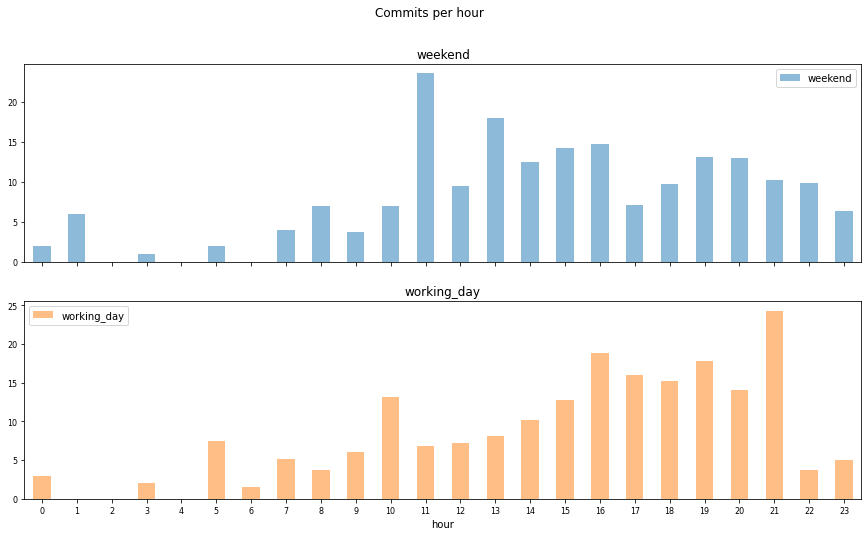

In [10]:
average_commit_counts_per_hour_df.plot.bar(subplots=True, 
                                           sharex=True,
                                           figsize=(15, 8),
                                           fontsize=8,
                                           title='Commits per hour',
                                           alpha=0.5,
                                           rot=0
                                          )

## Disconnect database

In [11]:
db_connection.close()

## Is the dynamic different on working days and weekends?

The answer is: yes it is:
* More commits at weekends are made at 11-16 hours (afternoon).
* More commits at working days are made at 16-21 hours (evening).